# Steam games analysis

## Introduction

Steam is a popular online platform which provides the user with automatic game updating, game cloud synchronization, and community features such as friends messaging, in-game chat and a community market. The focus of this project will be on the Steam Store page that contains a huge catalouge of games and has been constantly releasing multitude of games over the years from major developers to indie game designers. With it, comes varying opinons and ratings that can affect the game's popularity.

This project is to explore the recent new releases of such games to identify what affects the popularity of them. I wanted to use Natural Language Processing to explore the sentiments of the user reviews of different games to identify various key words.

## Aims and Objectives

Within this project, I would like to explore the following:

- Analysing games ratings and prices
- Identifying key words in reviews
- Measuring usage of words

For this project, my aims are to:

1. Decide how much data is required to sufficiently explore the above questions, taking into consideration constraints on time and resources
2. Collect the data via webscraping and store them in a form which allows for data cleaning and analysis
3. Clean and transform the data such that it is suitable for analysing
4. Carry out some exploratory data analysis to identify that there are trends within the data which make it viable for further exploration

## Data

I have chosen to try and retreive at least a year worth of games from the new releases page instead of top selling page as the latter games are usually positively reviewed. This allows me to gather negative and positive game ratings from across the year. The processed data will then be stored in pickle format to be read and clean.

### Limitations
However newly released games will not have any reviews available at the time, therefore will not have any data for ratings and reviews to extract from. Furthermore, several games have less than 10 reviews available which will impact the collection of data. Scraping a year worth of data takes a long time to complete, thus data extraction will only be done once in consideration with the time constraints. 

## Ethical considerations

Steam does not have a clause forbidding webscraping in their terms and conditions. I used robots.txt to check to ensure there was no Disallow clause on the site. Furthermore, all data provided are in the public domain. Any Steam user is able to write a review if they own the game thus some reviews may be harmful to others.

### Selenium

To get started, I installed Selenium to perform the webscrap as Steam website is a dynamic website, which allows for infinite scrolling on one page.

In [ ]:
#!pip install selenium
#!pip install word

In [1]:
# Import libraries and modules
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.select import Select
import time
import pickle
import nltk
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
import re
from string import punctuation
from nltk.corpus import stopwords
from nltk import FreqDist
from wordcloud import WordCloud
nltk.download('stopwords')
nltk.download('punkt')

### Webdriver

Below is the function to create a webdriver so that the website simulates it running on a website allowing the dynamic content to be loaded.

In [2]:
def web_driver(url):
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome(options=options)
    driver.get(url)
    return driver

### Scrolling

The below function simulates scrolling down to the bottom of the page

In [3]:
def scroll_page(driver):
    SCROLL_PAUSE_TIME = 2
    # Get scroll height
    last_height = driver.execute_script("return document.body.scrollHeight")
    # Loads the next page 190 times
    for i in range(190): 
        # Scroll down to bottom
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        # Wait to load page
        time.sleep(SCROLL_PAUSE_TIME)
        # Calculate new scroll height and compare with last scroll height
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
            last_height = new_height

### Extracting information

The functions below are to extract the game's information such as its app-id, title and url. 

In [4]:
def n_games(driver):
    games_rows = driver.find_element(By.ID, 'search_resultsRows')
    games = games_rows.find_elements(By.TAG_NAME,'a')
    return games

In [5]:
def parse_data(games):
    games_list = []
    #loops through all the games
    for i in range(len(games)):
        appid = games[i].get_attribute('data-ds-appid')
        title = games[i].find_element(By.CLASS_NAME,'title').text
        game_url = games[i].get_attribute('href')
        #storing the extracted information inside a dictionary
        game_data = {
            'appid': appid,
            'title': title,
            'url': game_url,
        }
        games_list.append(game_data)
    return games_list

### Bypassing

Certain games are blocked by an age restriction check, therefore the following function is created to bypass it.

In [6]:
def check_page(driver):
    try:
        try:
            info_tag = driver.find_element(By.CLASS_NAME, 'glance_ctn_responsive_left')
            return driver
        except:
            year_tag = driver.find_element(By.CLASS_NAME, 'agegate_birthday_selector')
            year = year_tag.find_element(By.ID, 'ageYear')
            yearDD = Select(year)
            yearDD.select_by_value('1900')
            view_button = driver.find_element(By.XPATH, '//*[@id="view_product_page_btn"]')
            view_button.click()
            time.sleep(4)
    except:
        return driver
    return driver

### Game's data

The follwing functions are to gather a game's price, release date and its ratings.

In [7]:
def get_price(driver):
    try:  
        try:  
            try:
                price_tag = driver.find_element(By.CLASS_NAME, 'game_purchase_action')
                # Removing $ and S$ from prices
                price = price_tag.find_element(By.CLASS_NAME, 'price').text.strip('$').strip('S$')
                try:
                    num = float(price)
                except ValueError:
                    price = '0'
                return price
            except:
                price_tag = driver.find_element(By.CLASS_NAME, 'discount_prices')
                prices = price_tag.text.strip().replace('\n')
                price = prices[1]
            return price
        except:
            price_tag = driver.find_element(By.CLASS_NAME, 'discount_prices')
            price = price_tag.find_element(By.CLASS_NAME, 'discount_original_price').text.split('$')[1]
        return price
    except:
        # If game is free to play or has no pricing available
        price = '0'
    return price

In [8]:
def get_release(driver):
    try:
        info_tag = driver.find_element(By.CLASS_NAME, 'glance_ctn_responsive_left')
        release = info_tag.find_element(By.CLASS_NAME, 'release_date').text.strip().replace('RELEASE DATE:\n','')
    except:
        release = 'not available'
    return release

In [9]:
def get_overall_reviews(driver):
    try:
        info_tag = driver.find_element(By.CLASS_NAME, 'glance_ctn_responsive_left')
        try:
            overall_reviews = info_tag.find_element(By.XPATH, '//*[@id="userReviews"]/div[2]').text.replace('ALL REVIEWS:\n', '')
        except:
            overall_reviews = info_tag.find_element(By.CLASS_NAME, 'user_reviews').text.replace('ALL REVIEWS:\n', '')
    except:
        overall_reviews = 'not available'
    return overall_reviews

In [10]:
def get_page(url, driver):
    driver.get(url)
    return driver

Takes the url and returns a dictionary

In [11]:
def get_game_info(url, driver):
    driver_1 = get_page(url, driver)
    driver_new = check_page(driver_1)
    price = get_price(driver_new)
    release = get_release(driver_new)
    overall_reviews = get_overall_reviews(driver_new)
    gamedata = {
            'Price': price,
            'Release date': release,
            'Reviews': overall_reviews
           }
    return gamedata

Function for looping through all games for their data by taking get_game_info function

In [12]:
def get_all_games(games_url, driver):
    game_info_list = []
    for i in games_url:
        game_info = get_game_info(i, driver)
        game_info_list.append(game_info)
        game_info_df = pd.DataFrame(game_info_list)
    return game_info_df

### Main

The main function is to execute all the previous function. Once the data has been gathered, I will combine the dataframes from gamesdf and game_info_df into result and dropping reviews that have 'no user reviews' and finally storing it into a pickle file.

In [13]:
def main():
    driver = web_driver('https://store.steampowered.com/search/?sort_by=Released_DESC&category1=998&supportedlang=english&hidef2p=1&ndl=1')
    scroll_page(driver)
    games = n_games(driver)
    games_list = parse_data(games)
    gamesdf = pd.DataFrame(games_list)
    gamesdf.to_pickle('Data/appid_games.pkl.gz', index=False)
    games_url = gamesdf['url']
    print(len(games_url))
    
    game_info_df = get_all_games(games_url, driver)
    
    result = pd.concat([gamesdf, game_info_df], axis=1, join='inner')
    result = result.drop(result[result.Reviews == 'No user reviews'].index)
    result.reset_index(drop=True, inplace=True)
    print(result)
    result.to_pickle('Data/new_releases.pkl.gz', index=False)

In [ ]:
main()

9550
        appid                           title  \
0     2162160                   The Passenger   
1     1877410                      Fairy Deer   
2     2251240            Police Car Simulator   
3     2225690                        HugeHead   
4     1267560                        In Space   
...       ...                             ...   
8198  1751630  Hello Lady! - Complete Edition   
8199  1827730                     Adarin Farm   
8200  1864210                      Zombie War   
8201  1451940         NEEDY STREAMER OVERLOAD   
8202  1863170               From Dusk To Dawn   

                                                    url  Price  Release date  \
0     https://store.steampowered.com/app/2162160/The...   7.50  30 Dec, 2022   
1     https://store.steampowered.com/app/1877410/Fai...   2.15  30 Dec, 2022   
2     https://store.steampowered.com/app/2251240/Pol...   1.10  29 Dec, 2022   
3     https://store.steampowered.com/app/2225690/Hug...   3.25  29 Dec, 2022   
4     https://store.steampowered.com/app/1267560/In_...   3.25  29 Dec, 2022   
...                                                 ...    ...           ...   
8198  https://store.steampowered.com/app/1751630/Hel...  26.00  21 Jan, 2022   
8199  https://store.steampowered.com/app/1827730/Ada...   6.50  21 Jan, 2022   
8200  https://store.steampowered.com/app/1864210/Zom...   7.50  21 Jan, 2022   
8201  https://store.steampowered.com/app/1451940/NEE...  15.00  21 Jan, 2022   
8202  https://store.steampowered.com/app/1863170/Fro...   7.50  21 Jan, 2022   

                                                Reviews  
0     1 user reviews - Need more user reviews to gen...  
1     6 user reviews - Need more user reviews to gen...  
2     1 user reviews - Need more user reviews to gen...  
3     1 user reviews - Need more user reviews to gen...  
4     1 user reviews - Need more user reviews to gen...  
...                                                 ...  
8198  Very Positive - 86% of the 95 user reviews for...  
8199  8 user reviews - Need more user reviews to gen...  
8200  2 user reviews - Need more user reviews to gen...  
8201  Overwhelmingly Positive - 95% of the 18,078 us...  
8202  7 user reviews - Need more user reviews to gen...  

[8203 rows x 6 columns]

### Checking and preparing for processing

Reading the pickle file to dataframe.

In [14]:
nr_df = pd.read_pickle('Data/new_releases.pkl.gz')
nr_df.head(10)

,appid,title,url,Price,Release date,Reviews
0,2162160,The Passenger,https://store.steampowered.com/app/2162160/The...,7.50,"30 Dec, 2022",1 user reviews - Need more user reviews to gen...
1,1877410,Fairy Deer,https://store.steampowered.com/app/1877410/Fai...,2.15,"30 Dec, 2022",6 user reviews - Need more user reviews to gen...
2,2251240,Police Car Simulator,https://store.steampowered.com/app/2251240/Pol...,1.10,"29 Dec, 2022",1 user reviews - Need more user reviews to gen...
3,2225690,HugeHead,https://store.steampowered.com/app/2225690/Hug...,3.25,"29 Dec, 2022",1 user reviews - Need more user reviews to gen...
4,1267560,In Space,https://store.steampowered.com/app/1267560/In_...,3.25,"29 Dec, 2022",1 user reviews - Need more user reviews to gen...
5,2241880,Gunslinger Top down shooter,https://store.steampowered.com/app/2241880/Gun...,2.15,"29 Dec, 2022",1 user reviews - Need more user reviews to gen...
6,2244620,Blacklight,https://store.steampowered.com/app/2244620/Bla...,3.05,"29 Dec, 2022",1 user reviews - Need more user reviews to gen...
7,1572320,Malfunction II,https://store.steampowered.com/app/1572320/Mal...,0.00,"29 Dec, 2022",2 user reviews - Need more user reviews to gen...
8,2217730,theBlu,https://store.steampowered.com/app/2217730/the...,0.00,"29 Dec, 2022",8 user reviews - Need more user reviews to gen...
9,2235350,Family Business,https://store.steampowered.com/app/2235350/Fam...,5.25,"29 Dec, 2022",1 user reviews - Need more user reviews to gen...


In [15]:
nr_df.tail(10)

,appid,title,url,Price,Release date,Reviews
8193,1737510,Hardworking Hero,https://store.steampowered.com/app/1737510/Har...,0.00,"21 Jan, 2022",7 user reviews - Need more user reviews to gen...
8194,1727020,爆Z联,https://store.steampowered.com/app/1727020/Z/?...,0.00,"21 Jan, 2022",9 user reviews - Need more user reviews to gen...
8195,1803620,The Monstrous Frontier,https://store.steampowered.com/app/1803620/The...,14.50,"21 Jan, 2022",4 user reviews - Need more user reviews to gen...
8196,1488650,Velocity Noodle,https://store.steampowered.com/app/1488650/Vel...,13.00,"21 Jan, 2022",Positive - 95% of the 20 user reviews for this...
8197,1835870,The Black Cat Magician,https://store.steampowered.com/app/1835870/The...,4.25,"21 Jan, 2022",Very Positive - 91% of the 190 user reviews fo...
8198,1751630,Hello Lady! - Complete Edition,https://store.steampowered.com/app/1751630/Hel...,26.00,"21 Jan, 2022",Very Positive - 86% of the 95 user reviews for...
8199,1827730,Adarin Farm,https://store.steampowered.com/app/1827730/Ada...,6.50,"21 Jan, 2022",8 user reviews - Need more user reviews to gen...
8200,1864210,Zombie War,https://store.steampowered.com/app/1864210/Zom...,7.50,"21 Jan, 2022",2 user reviews - Need more user reviews to gen...
8201,1451940,NEEDY STREAMER OVERLOAD,https://store.steampowered.com/app/1451940/NEE...,15.00,"21 Jan, 2022","Overwhelmingly Positive - 95% of the 18,078 us..."
8202,1863170,From Dusk To Dawn,https://store.steampowered.com/app/1863170/Fro...,7.50,"21 Jan, 2022",7 user reviews - Need more user reviews to gen...


From the head and tail functions, we can see that many of the games in the past year have less than 10 reviews available.

In [16]:
nr_df.describe().round(2)

,Price
count,8203.00
mean,10.43
std,14.37
min,0.00
25%,3.25
50%,6.50
75%,14.50
max,525.00


#### Checking datatype

In [17]:
nr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8203 entries, 0 to 8202
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   appid         8203 non-null   object 
 1   title         8203 non-null   object 
 2   url           8203 non-null   object 
 3   Price         8203 non-null   float64
 4   Release date  8203 non-null   object 
 5   Reviews       8203 non-null   object 
dtypes: float64(1), object(5)
memory usage: 384.6+ KB


### Converting datatype

Reviews datatype needed to be converted from object to string in order for further analysis.

In [18]:
nr_df = nr_df.astype({'Reviews':'string'})
print(nr_df.dtypes)

appid            object
title            object
url              object
Price           float64
Release date     object
Reviews          string
dtype: object


I replace the following ratings into numbers to be able to plot it onto a graph.

In [19]:
ratings = nr_df['Reviews'].str.split('-', expand = True)
b = 0
for i in ratings[0]:
    temp = i.strip().lower()
    if temp == 'overwhelmingly positive':
        ratings[0][b] = '9'
    elif temp == 'very positive':
        ratings[0][b] = '8'
    elif temp == 'mostly positive':
        ratings[0][b] = '7'
    elif temp == 'positive':
        ratings[0][b] = '6'
    elif temp == 'mixed':
        ratings[0][b] = '5'
    elif temp == 'negative':
        ratings[0][b] = '4'
    elif temp == 'mostly negative':
        ratings[0][b] = '3'
    elif temp == 'very negative':
        ratings[0][b] = '2'
    elif temp == 'overwhelmingly negative':
        ratings[0][b] = '1'
    else:
        ratings[0][b] = '0'
    b += 1
print(ratings[0])

0       0
1       0
2       0
3       0
4       0
       ..
8198    8
8199    0
8200    0
8201    9
8202    0
Name: 0, Length: 8203, dtype: string


Text(0, 0.5, 'Games')

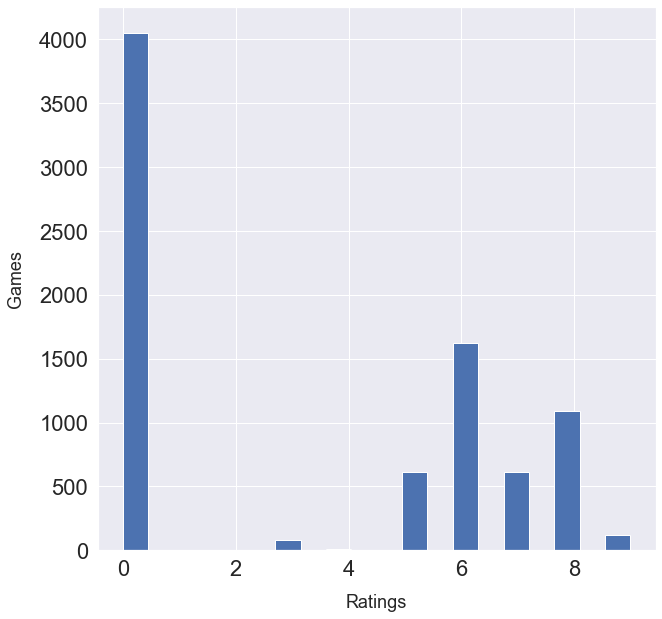

In [20]:
sns.set(font_scale=2)
ratings = ratings.astype({0:'int'})
ratings[0].plot(kind='hist', bins = 20, figsize=(10, 10))
plt.xlabel("Ratings", labelpad=14, fontsize=18)
plt.ylabel("Games", labelpad=14, fontsize=18)

Here we can see that there is a vast majority of games with not enough ratings available to determine if the game is good or bad. The highest available rating is 6, being positive while the next is 8 which is very positive. Thus, we can infer that the vast majority of the games recently released does not receive the players attention or the players did not deem it worthy to review the game. While at the same time, the games that players reviewed are mostly positive.

Text(0, 0.5, 'Games')

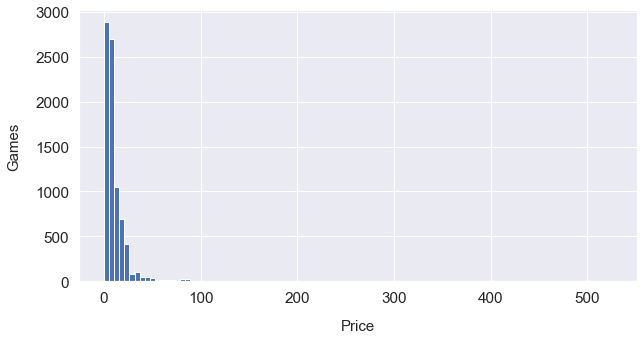

In [21]:
sns.set(font_scale=1.4)
nr_df['Price'].plot(kind='hist', bins = 100, figsize=(10, 5))
plt.xlabel("Price", labelpad=14, fontsize=15)
plt.ylabel("Games", labelpad=14, fontsize=15)

In this plot, we can see that the price for the majority of the released games in the past year has been between 0 - 50 dollars. With an exception of a couple of games being sold for more than 200 dollars. 

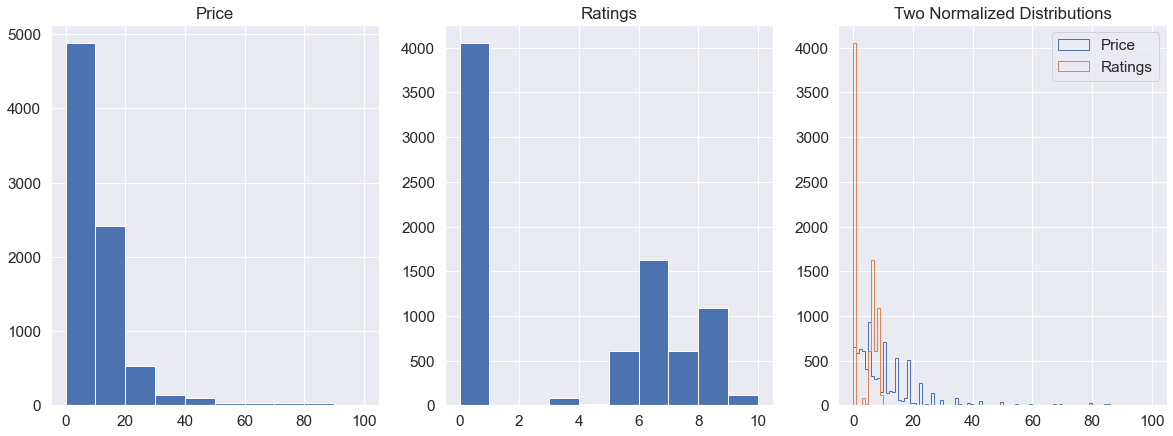

In [22]:
fig, axes = plt.subplots(1, 3, figsize = (20,7))
ax1, ax2, ax3 = fig.axes

ax1.hist(nr_df['Price'], bins = 10, range = (0,100))
ax1.set_title('Price')

ax2.hist(ratings[0], bins = 10, range = (0,10))
ax2.set_title('Ratings')

ax3.hist(nr_df['Price'], bins = 100, range = (0,100), histtype = 'step', label = 'Price')
ax3.hist(ratings[0], bins = 10, range = (0,10), histtype = 'step', label = 'Ratings')
ax3.set_title('Two Normalized Distributions')
plt.legend()

plt.show()

Based on the plots, we can see that the some similarities between prices and ratings. With almost 5000 games being less than 10 dollars. However, we also have a huge number of ratings that are at 0 meaning that those games do not have enough reviews or have none at all. From this, we can infer that despite games releasing at very low prices or being free, it does not mean that users will purchase or play those games. Many of such games will eventually be overshadowed by better reviewed games and will be forgotten.

Meanwhile, we can also see that the majority of the games that scored a 6 which is a positive review usually are between 10 to 20 dollars. This meant that players that bought the games will usually write psoitively on those games. It can also be inferred that with the low pricing of said games, the players can easily get access to them and will view them positively.

## User Reviews

To get a better understanding of what users like about those games, I decided to scrape for user reviews for each game available using the existing app ids I collected in the appid_games.pkl.gz file.

### Getting App ids

As each Steam game has a unique app id, we can use them to identify each game and get their reviews from it.

In [23]:
app_ids_df = pd.read_pickle('Data/appid_games.pkl.gz')
app_ids_df

,appid,title,url
0,2236350,Medieval Defence,https://store.steampowered.com/app/2236350/Med...
1,2236320,Ice Battle,https://store.steampowered.com/app/2236320/Ice...
2,2094390,HELLPIT,https://store.steampowered.com/app/2094390/HEL...
3,1970610,Duterra,https://store.steampowered.com/app/1970610/Dut...
4,2218780,The Epic FishHead Adventure,https://store.steampowered.com/app/2218780/The...
...,...,...,...
9545,1827730,Adarin Farm,https://store.steampowered.com/app/1827730/Ada...
9546,1864210,Zombie War,https://store.steampowered.com/app/1864210/Zom...
9547,1451940,NEEDY STREAMER OVERLOAD,https://store.steampowered.com/app/1451940/NEE...
9548,1408930,Greedy Corgi,https://store.steampowered.com/app/1408930/Gre...


### Separated appid column using numpy function.

In [24]:
app_ids = app_ids_df['appid'].to_numpy()
app_ids, len(app_ids)

(array(['2236350', '2236320', '2094390', ..., '1451940', '1408930',
        '1863170'], dtype=object),
 9550)

### Getting User Reviews

To get the user reviews for each individual game, I created a function to enable the success of getting the reviews and then enumerated through all the app ids found in the dataframe. I also decided to retrieve at least 100 reviews for each game if available to have a better dataset to sort through.

In [25]:
def user_reviews(appid, params):
    url = 'https://store.steampowered.com/appreviews/'
    response = requests.get(url=url+str(appid), params=params, headers={'User-Agent': 'Mozilla/5.0'})
    return response.json()

In [26]:
u_reviews = []
cursor = '*'
params = {
    'json' : 1,
    'filter' : 'all', #sort by: recent, updated, all (helpfullness)
    'language' : 'english', #language
    'day_range' : 9223372036854775807, #shows reveiws from all time
    'review_type' : 'all', #all, positive, negative
    'purchase_type' : 'all', #all, non_steam_purchase, steam
    'num_per_page' : 100, #number of reviews to get
    'cursor' : '*'.encode()
}

In [27]:
for i, app_id in enumerate(app_ids):
    u_reviews += user_reviews(app_id, params)['reviews']
    if (i+1)%500 == 0:
        print(f'{i+1} of {len(app_ids)}: {len(u_reviews)} reviews')

500 of 9550: 6587 reviews
1000 of 9550: 14377 reviews
1500 of 9550: 21844 reviews
2000 of 9550: 29937 reviews
2500 of 9550: 40037 reviews
3000 of 9550: 49343 reviews
3500 of 9550: 61067 reviews
4000 of 9550: 71040 reviews
4500 of 9550: 80533 reviews
5000 of 9550: 91051 reviews
5500 of 9550: 100418 reviews
6000 of 9550: 111688 reviews
6500 of 9550: 122165 reviews
7000 of 9550: 133254 reviews
7500 of 9550: 145489 reviews
8000 of 9550: 157015 reviews
8500 of 9550: 167082 reviews
9000 of 9550: 176242 reviews
9500 of 9550: 185840 reviews


### Getting review data

Printed the first review to find the data I needed to store.

In [28]:
print(u_reviews[0])

{'recommendationid': '129649634', 'author': {'steamid': '76561198271724770', 'num_games_owned': 106, 'num_reviews': 35, 'playtime_forever': 335, 'playtime_last_two_weeks': 335, 'playtime_at_review': 182, 'last_played': 1672660698}, 'language': 'english', 'review': 'Before this came out I\'d already played the demo countless times, so I was not surprised at all by how good the finished product was. Seriously, this is one damn good game, totally recommend it. I\'ve yet to explore other paths, but the one ending I\'ve got was satisfying, albeit not exactly what I was looking for. Really liked the epilogue, it always feels nice to remain a bit in the world even after the story is done, just to check on the characters and all that. Only complain I have is that towards the ending the main character seemed to care far too much about other when considering the choices I picked. I didn\'t pick the outright "mean" options but I also don\'t think I picked to be "loving" or "caring". I don\'t know

In [29]:
user_reviews_df = pd.DataFrame(u_reviews)[['review', 'voted_up']]
user_reviews_df

,review,voted_up
0,Before this came out I'd already played the de...,True
1,"The Passenger is a story of self discovery, of...",True
2,JONNY I WILL ALWAYS BE YOUR BIGGEST FAN. THATS...,True
3,Been hooked on this story ever since I read th...,True
4,I've been following this game's development fo...,True
...,...,...
186606,I CAN FIX HER.I CAN FIX HER.I CAN FIX HER.I CA...,True
186607,I love mental health,True
186608,I can relate to her... does that mean I need t...,True
186609,"[quote]For more puzzle game reviews, news and ...",True


In [30]:
user_reviews_df.voted_up.value_counts(normalize=True)

True     0.806357
False    0.193643
Name: voted_up, dtype: float64

In [31]:
user_reviews_df.describe()

,review,voted_up
count,186611,186611
unique,181279,2
top,good,True
freq,219,150475


In [32]:
user_reviews_df.to_pickle('Data/user_reviews_raw.pkl.gz')

## Stopwords

The stopwords list is created to remove punctuations as well as basic english words. To help gather a more accurate data, I added in some custom words I found to be filtered out too.

In [33]:
stopwords_list = list(punctuation) + ['`', '’', '…', '\n'] + stopwords.words('english') + ['game', 'games', 'also', 'really', 'would', 'like', 'get', 'still', 'way', 'could', 'b']
print(stopwords_list)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '`', '’', '…', '\n', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'h

## Tokenizing words

In [34]:
def tokenize(review):
    if not review or pd.isnull(review):
        return []
    tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+') # tokenize words with only numbers and latin characters
    return tokenizer.tokenize(review.lower())

In [35]:
raw_df = pd.read_pickle('Data/user_reviews_raw.pkl.gz')

raw_df['tokens'] = raw_df['review'].apply(tokenize)

vote_up = raw_df['voted_up'].to_numpy()
pd.DataFrame(vote_up, columns=['voted_up']).to_pickle('Data/vote_up.pkl.gz', index=False)

token_df = raw_df['tokens'].to_numpy()

token_stopword = []
for review in token_df:
    token_stopword.append([word for word in review if word not in stopwords_list])
pd.DataFrame([' '.join(review) for review in token_stopword], columns=['review']).to_pickle('Data/token_stopword.pkl.gz', index=False)

## Combining both pickle files

In [36]:
token_data = pd.read_pickle('Data/token_stopword.pkl.gz')
vote_up_data = pd.read_pickle('Data/vote_up.pkl.gz')
all_data = pd.concat([token_data, vote_up_data], axis=1)
all_data

,review,voted_up
0,came already played demo countless times surpr...,True
1,passenger story self discovery want become fig...,True
2,jonny always biggest fan thats wife,True
3,hooked story ever since read demo years ago ca...,True
4,following development year unbelievably please...,True
...,...,...
186606,fix fix fix fix fix fix fix fix fix fix fix fi...,True
186607,love mental health,True
186608,relate mean need therapy lol,True
186609,quote puzzle reviews news everything puzzle re...,True


## Cleaning empty reviews

In [37]:
all_data = all_data.dropna(subset=['review'])
all_data = all_data.fillna(' ')

## Finding unique vocabulary

In [38]:
total_vocabulary = []
for review in all_data['review'].tolist():
    total_vocabulary += review.split()

In [39]:
print('There are {} unique tokens in the dataset.'.format(len(set(total_vocabulary))))

There are 128446 unique tokens in the dataset.


## Top 20 common words

In [40]:
freqdist = FreqDist(total_vocabulary)
top_20 = freqdist.most_common(20)

words, values = list(zip(*top_20))

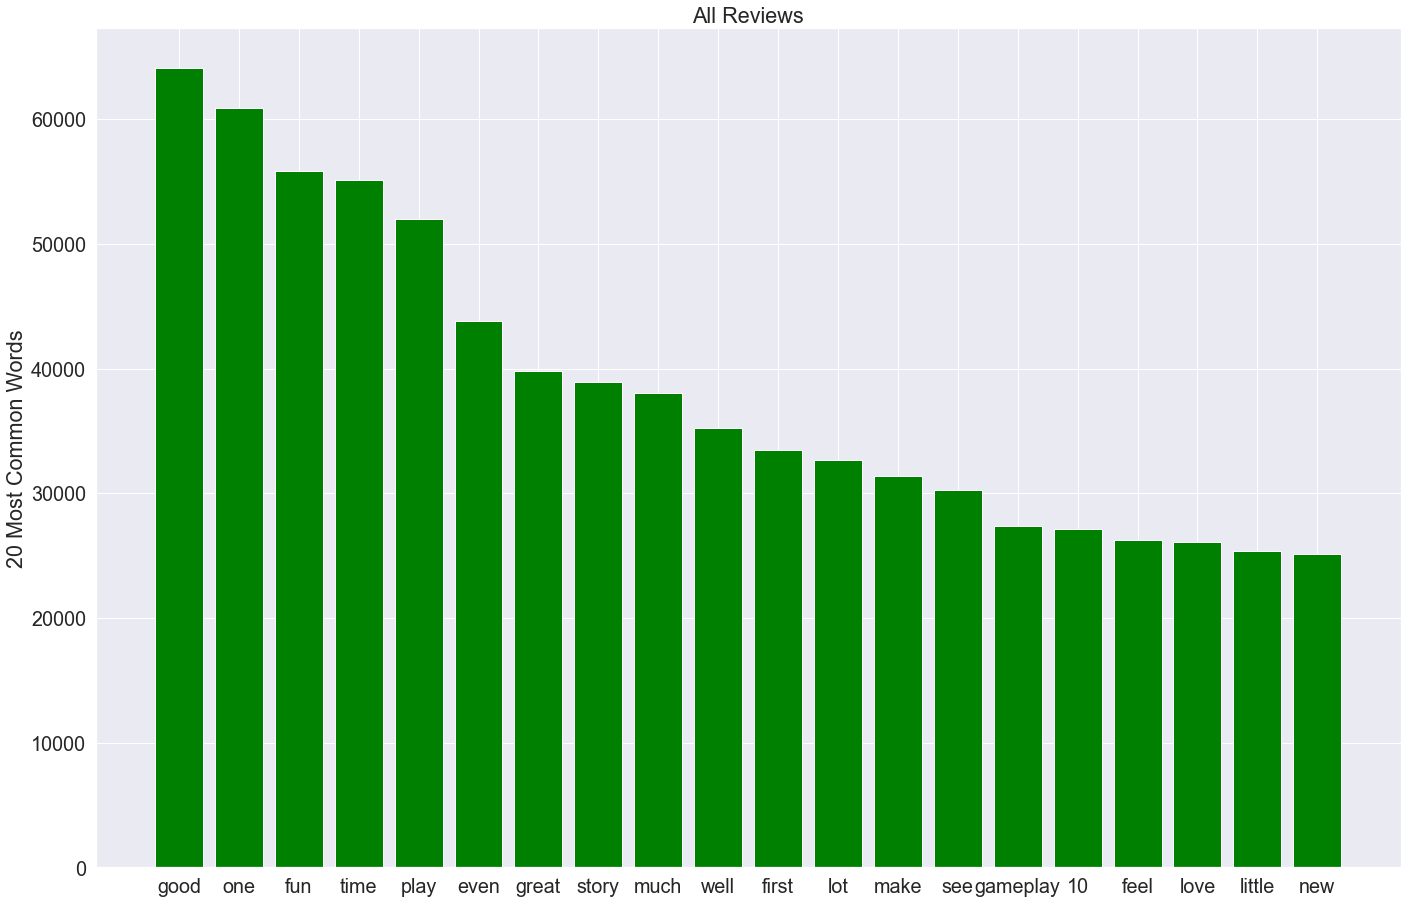

In [41]:
sns.set(font_scale=1.8)
fig = plt.figure(figsize=(20, 13))
plt.bar(words, values, figure=fig, color=['green'])
plt.ylabel('20 Most Common Words')
plt.title('All Reviews')

plt.tight_layout()
plt.show()

The data shows the top 20 most common words used and we can see that majority of the users commented 'good' followed by 'one' then 'fun' on the games. Within this top 20 words, there are hardly any negative words inside. With this, we can infer that many users reviewed positively on the games in the past year.

## Separating Positive and Negative reviews

I wanted to split the positive reviews and negative reviews so that I am able to identify the commonly used words more accurately.

In [42]:
vote_true = pd.read_pickle('Data/vote_up.pkl.gz')
vote_true = vote_true.drop(vote_true[vote_true.voted_up == False].index)
vote_true

,voted_up
0,True
1,True
2,True
3,True
4,True
...,...
186605,True
186606,True
186607,True
186608,True


In [43]:
vote_false = pd.read_pickle('Data/vote_up.pkl.gz')
vote_false = vote_false.drop(vote_false[vote_false.voted_up == True].index)
vote_false

,voted_up
18,False
20,False
26,False
50,False
62,False
...,...
186467,False
186470,False
186483,False
186502,False


In [44]:
vote_true_data = pd.concat([token_data, vote_true], axis=1, join='inner')
vote_true_data.reset_index(drop=True, inplace=True)
vote_true_data

,review,voted_up
0,came already played demo countless times surpr...,True
1,passenger story self discovery want become fig...,True
2,jonny always biggest fan thats wife,True
3,hooked story ever since read demo years ago ca...,True
4,following development year unbelievably please...,True
...,...,...
150470,playing giving 10 mental darkness hour 5 stres...,True
150471,fix fix fix fix fix fix fix fix fix fix fix fi...,True
150472,love mental health,True
150473,relate mean need therapy lol,True


In [45]:
vote_false_data = pd.concat([token_data, vote_false], axis=1, join='inner')
vote_false_data.reset_index(drop=True, inplace=True)
vote_false_data

,review,voted_up
0,started found excited concept playing decided ...,False
1,think people write lost respect readers mean t...,False
2,utter garbage complete waste time disclaimer p...,False
3,pay creator 10 remove steam,False
4,6 years since much squid added fairly disappoi...,False
...,...,...
36131,great fan nekonyan one meh begin cringe utmost...,False
36132,wow bad cant stop self skipping dialog bad don...,False
36133,aggressively mediocre throughout play time,False
36134,dont know recommend know played 40 minutes soo...,False


In [46]:
vote_true_data = vote_true_data.dropna(subset=['review'])
vote_true_data = vote_true_data.fillna(' ')

vote_false_data = vote_false_data.dropna(subset=['review'])
vote_false_data = vote_false_data.fillna(' ')

vote_true_vocabulary = []
for review in vote_true_data['review'].tolist():
    vote_true_vocabulary += review.split()
    
vote_false_vocabulary = []
for review in vote_false_data['review'].tolist():
    vote_false_vocabulary += review.split()

In [47]:
print('There are {} unique tokens in the dataset.'.format(len(set(vote_true_vocabulary))))
print('There are {} unique tokens in the dataset.'.format(len(set(vote_false_vocabulary))))

There are 111160 unique tokens in the dataset.
There are 58885 unique tokens in the dataset.


## Top 20 common words

The code below is to identify the 20 most commonly used words in the positive and negative reviews seperately.

In [48]:
freqdist_pos = FreqDist(vote_true_vocabulary)
top_20_pos = freqdist_pos.most_common(20)

freqdist_neg = FreqDist(vote_false_vocabulary)
top_20_neg = freqdist_neg.most_common(20)

words_pos, values_pos = list(zip(*top_20_pos))
words_neg, values_neg = list(zip(*top_20_neg))

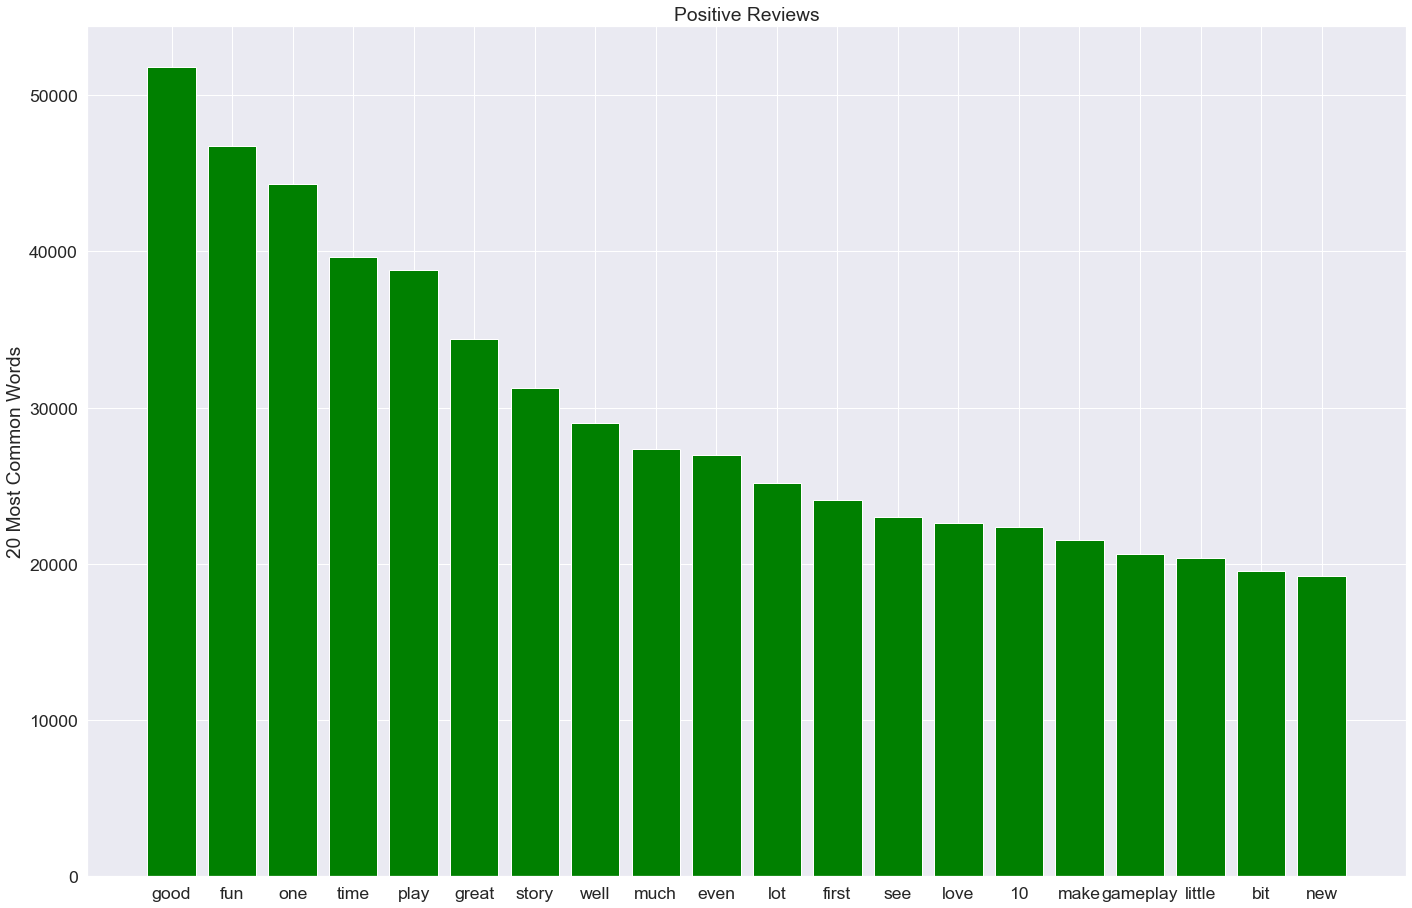

In [49]:
sns.set(font_scale=1.6)
fig = plt.figure(figsize=(20, 13))
plt.bar(words_pos, values_pos, figure=fig, color='green')
plt.ylabel('20 Most Common Words')
plt.title('Positive Reviews')

plt.tight_layout()
plt.show()

From this plot, we can see that it is similar to the previous all reviews plot. The top 20 words are positive where 'good', 'fun' and 'one' are in the top 3 used words.

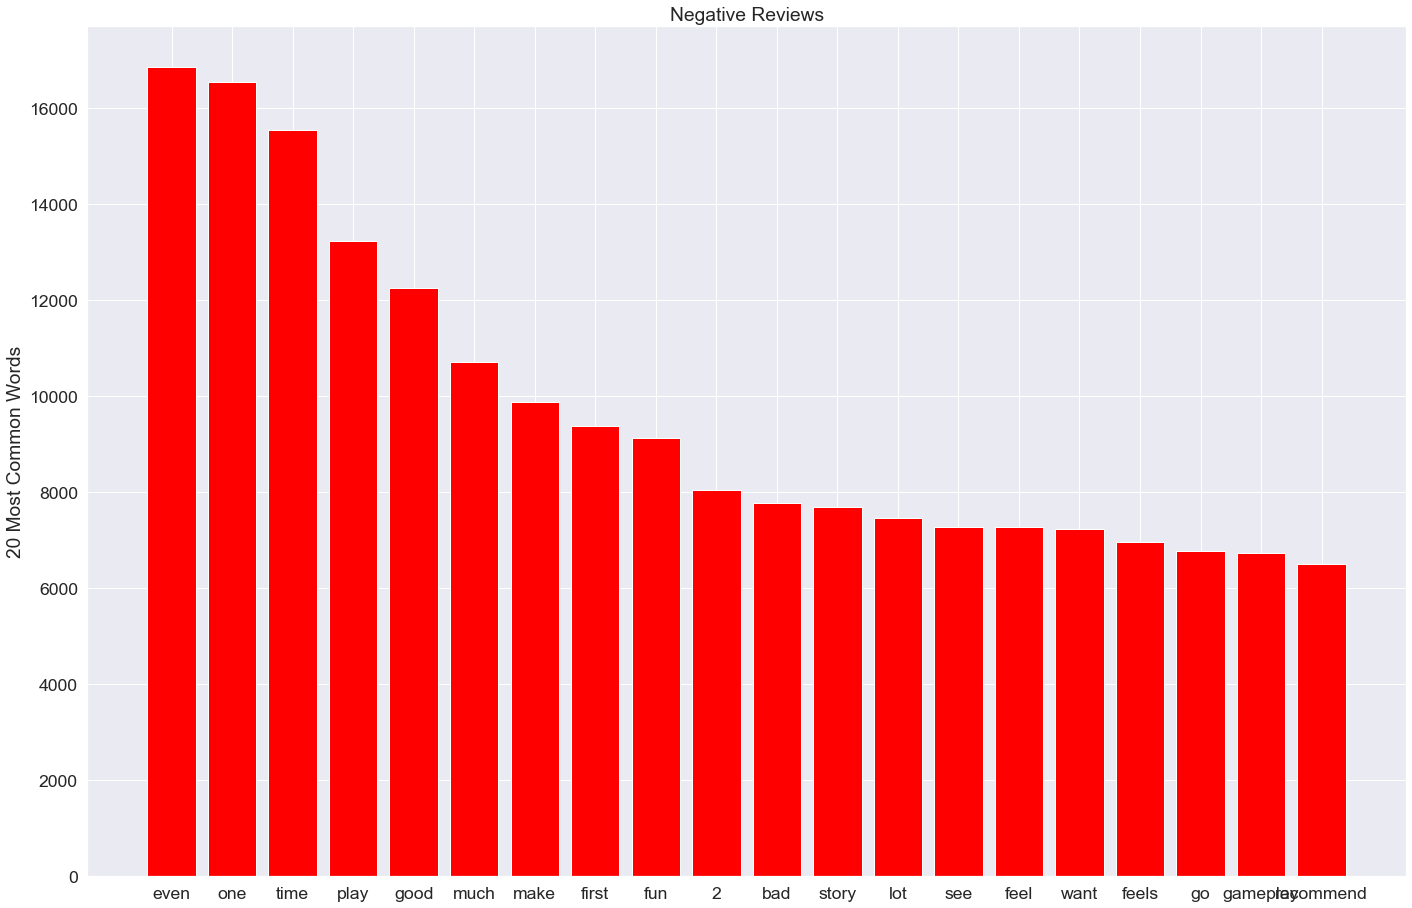

In [50]:
sns.set(font_scale=1.6)
fig = plt.figure(figsize=(20, 13))
plt.bar(words_neg, values_neg, figure=fig, color='red')
plt.ylabel('20 Most Common Words')
plt.title('Negative Reviews')

plt.tight_layout()
plt.show()

In this plot, dispite focusing on the negative reviews, many positive words are in the plot such as 'good', 'fun' and 'one'. 

In [51]:
positive_dict = dict(zip(words_pos, values_pos))
negative_dict = dict(zip(words_neg, values_neg))

## Wordcloud

I generated a wordcloud for the positive and negative words used to help identify the unique words used most commonly.

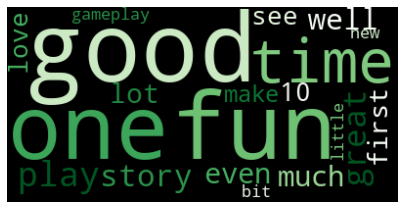

In [52]:
wordcloud = WordCloud(colormap='Greens').generate_from_frequencies(positive_dict)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.tight_layout()
plt.show()

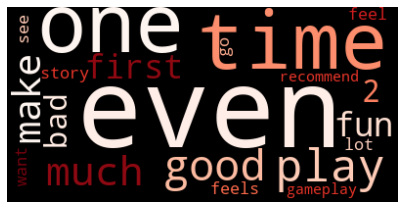

In [53]:
wordcloud = WordCloud(colormap='Reds').generate_from_frequencies(negative_dict)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.tight_layout()
plt.show()

## Summary

In conclusion, from the data explored, by comparing between the ratings and prices, we can tell that from the past year, the vast majority of the games that have low pricing are published by indie developers. This largely affects the user's interest as majority of them will not look for these games. This contributes to many of the ratings being 0 whereby there is not enough reviews to determine the game's rating. With that said, from the analysis, the general sentiment of the public to the recently release games that have been played and reviewed are generally positive to very positive.

Furthermore, from the user reviews extracted, many of the most common words are used in both cases. Words like "fun" and "one" appear numerous times, and even "time" has similar representation across the two cases. The frequency distribution charts and wordclouds above show this well. With the positive sentiment from the public, it makes sense that several key words appear in both cases. However some words that do appear lack the context at hand or do not have any meaning to them such as "see", "feel" and "much". 

### References

1. Selenium documentation library : https://pypi.org/project/selenium/
2. Selenium 4.7 documentation: https://www.selenium.dev/selenium/docs/api/py/webdriver/selenium.webdriver.common.by.html
3. Steam website(New releases): https://store.steampowered.com/search/?sort_by=Released_DESC&category1=998&ndl=1
4. Steamworks Documentation: https://partner.steamgames.com/doc/webapi/ISteamApps
5. Steamworks Documentation - User Reviews - Get List: https://partner.steamgames.com/doc/store/getreviews
6. Plot multiple plots in Matplotlib: https://www.geeksforgeeks.org/plot-multiple-plots-in-matplotlib/
7. DataFrame plot: https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.DataFrame.plot.html
8. Stopwords: https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
9. NLTK Library: https://www.nltk.org/